# Data Exploration Script for Coffee Bean Defect Detection

Explores dataset structure, class distribution, and image characteristics

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
import cv2
from collections import defaultdict

In [2]:
# Set project paths
PROJECT_ROOT = Path('/home/tony/research_project/iate_project')
DATA_DIR = PROJECT_ROOT / 'data' / 'raw'
RESULTS_DIR = PROJECT_ROOT / 'results'
FIGURES_DIR = RESULTS_DIR / 'figures'

In [3]:
# Create directories if they don't exist
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 1. Dataset structure analysis

In [5]:
dataset_structure = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
all_images = []
image_sizes = []
color_channels = []

for class_name in ['normal', 'defect']:
    class_path = DATA_DIR / class_name
    if not class_path.exists():
        print(f"Warning: {class_path} does not exist")
        continue

    for process_method in ['dry', 'honey', 'wet']:
        process_path = class_path / process_method
        if not process_path.exists():
            continue

        for roast_level in ['dark', 'medium', 'light']:
            roast_path = process_path / roast_level
            if not roast_path.exists():
                continue

            # Count images
            image_files = [p for p in roast_path.iterdir() if p.is_file() and p.suffix.lower() in {'.jpg', '.jpeg', '.png'}]

            count = len(image_files)
            dataset_structure[class_name][process_method][roast_level] = count

            # Sample image for size analysis
            if image_files and len(image_sizes) < 100:
                for img_file in image_files[:10]:
                    img = Image.open(img_file)
                    image_sizes.append(img.size)
                    color_channels.append(img.mode)
                    all_images.append({
                        'path': str(img_file),
                        'class': class_name,
                        'process': process_method,
                        'roast': roast_level,
                        'size': img.size
                    })

# Print dataset structure
for class_name in dataset_structure:
    print(f"\n{class_name}:")
    for process in dataset_structure[class_name]:
        for roast in dataset_structure[class_name][process]:
            count = dataset_structure[class_name][process][roast]
            print(f"  {process}/{roast}: {count} images")


normal:
  dry/dark: 400 images
  dry/medium: 400 images
  dry/light: 400 images
  honey/dark: 400 images
  honey/medium: 400 images
  honey/light: 400 images
  wet/dark: 400 images
  wet/medium: 400 images
  wet/light: 400 images

defect:
  dry/dark: 200 images
  dry/medium: 200 images
  dry/light: 200 images
  honey/dark: 200 images
  honey/medium: 200 images
  honey/light: 200 images
  wet/dark: 200 images
  wet/medium: 200 images
  wet/light: 200 images


# 2. Dataset Statistics

In [6]:
total_normal = sum(
    dataset_structure['normal'][p][r]
    for p in dataset_structure['normal']
    for r in dataset_structure['normal'][p]
)
total_defect = sum(
    dataset_structure['defect'][p][r]
    for p in dataset_structure['defect']
    for r in dataset_structure['defect'][p]
)
total_images = total_normal + total_defect

print(f"Total Normal beans: {total_normal} ({total_normal/total_images*100:.1f}%)")
print(f"Total Defect beans: {total_defect} ({total_defect/total_images*100:.1f}%)")
print(f"Total images: {total_images}")
print(f"Class ratio (Normal:Defect): {total_normal/total_defect:.2f}:1")

Total Normal beans: 3600 (66.7%)
Total Defect beans: 1800 (33.3%)
Total images: 5400
Class ratio (Normal:Defect): 2.00:1


In [7]:
# Image size analysis
if image_sizes:
    widths, heights = zip(*image_sizes)
    print(f"\nImage dimensions:")
    print(f"  Width range: {min(widths)} - {max(widths)} pixels")
    print(f"  Height range: {min(heights)} - {max(heights)} pixels")
    print(f"  Most common size: {max(set(image_sizes), key=image_sizes.count)}")
    print(f"  Color modes: {set(color_channels)}")


Image dimensions:
  Width range: 376 - 600 pixels
  Height range: 376 - 600 pixels
  Most common size: (400, 400)
  Color modes: {'RGB'}


# 3. Creating visualizations

Saved: dataset_exploration.png


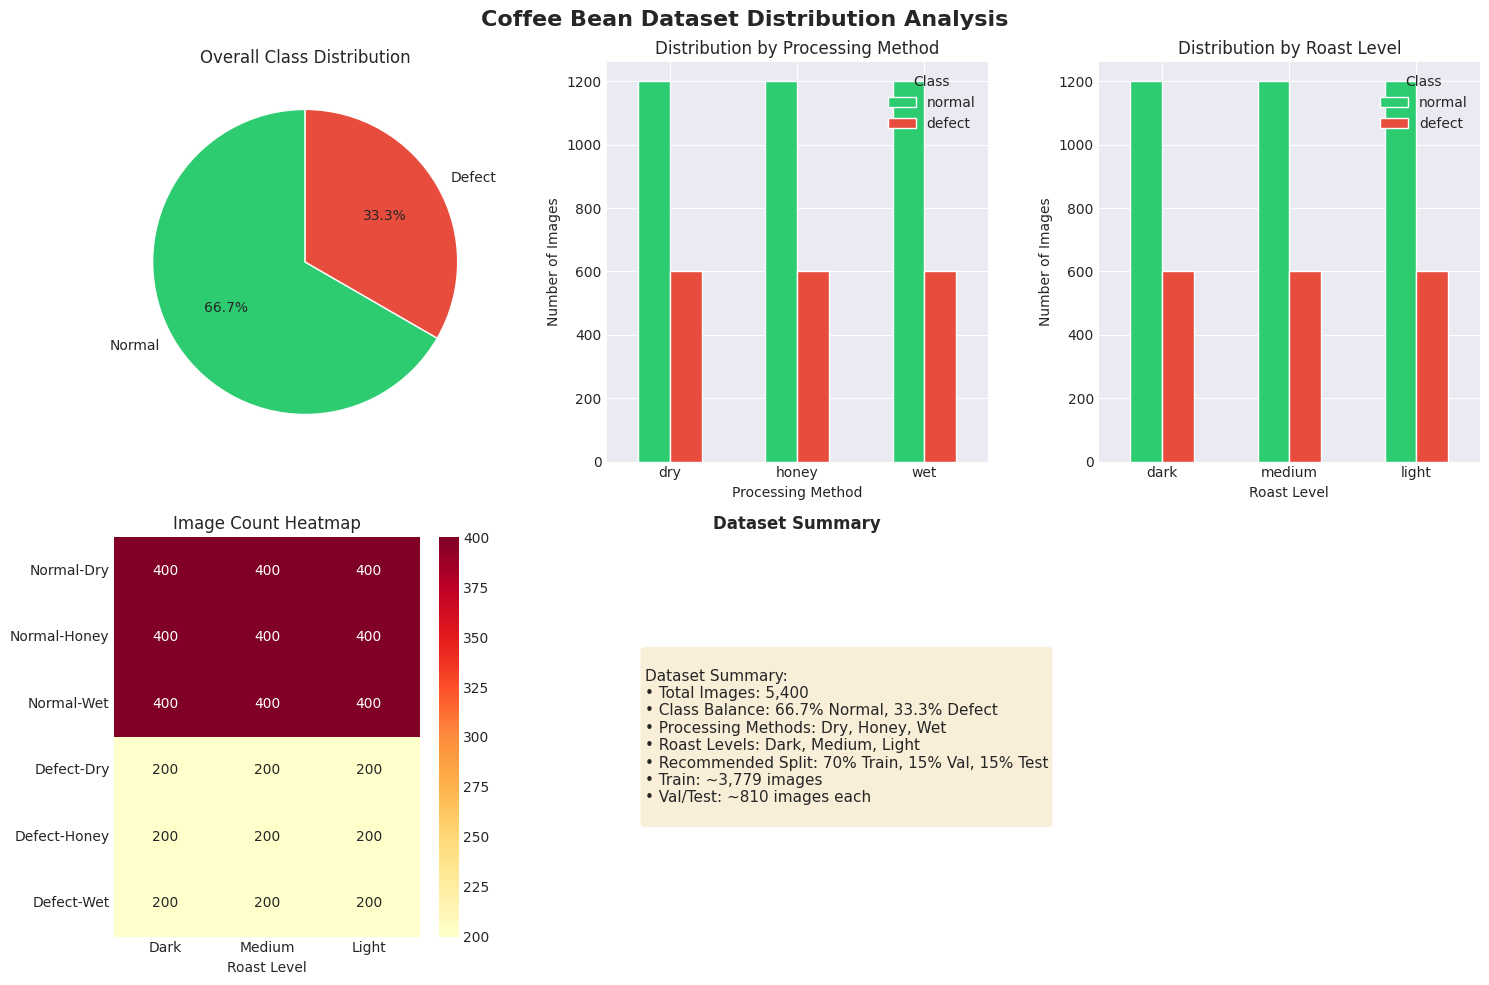

In [8]:
# Figure 1: Class distribution pie chart
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Coffee Bean Dataset Distribution Analysis', fontsize=16, fontweight='bold')

# Overall class distribution
ax = axes[0, 0]
sizes = [total_normal, total_defect]
labels = ['Normal', 'Defect']
colors = ['#2ecc71', '#e74c3c']
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax.set_title('Overall Class Distribution')

# Distribution by processing method
ax = axes[0, 1]
process_counts = defaultdict(lambda: defaultdict(int))
for class_name in dataset_structure:
    for process in dataset_structure[class_name]:
        for roast in dataset_structure[class_name][process]:
            process_counts[process][class_name] += dataset_structure[class_name][process][roast]

process_df = pd.DataFrame(process_counts).T
process_df.plot(kind='bar', ax=ax, color=['#2ecc71', '#e74c3c'])
ax.set_title('Distribution by Processing Method')
ax.set_xlabel('Processing Method')
ax.set_ylabel('Number of Images')
ax.legend(title='Class')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Distribution by roast level
ax = axes[0, 2]
roast_counts = defaultdict(lambda: defaultdict(int))
for class_name in dataset_structure:
    for process in dataset_structure[class_name]:
        for roast in dataset_structure[class_name][process]:
            roast_counts[roast][class_name] += dataset_structure[class_name][process][roast]

roast_df = pd.DataFrame(roast_counts).T
roast_df.plot(kind='bar', ax=ax, color=['#2ecc71', '#e74c3c'])
ax.set_title('Distribution by Roast Level')
ax.set_xlabel('Roast Level')
ax.set_ylabel('Number of Images')
ax.legend(title='Class')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Heatmap of distribution
ax = axes[1, 0]
heatmap_data = []
labels_y = []
for class_name in ['normal', 'defect']:
    for process in ['dry', 'honey', 'wet']:
        row = []
        for roast in ['dark', 'medium', 'light']:
            count = dataset_structure.get(class_name, {}).get(process, {}).get(roast, 0)
            row.append(count)
        heatmap_data.append(row)
        labels_y.append(f"{class_name.title()}-{process.title()}")

sns.heatmap(heatmap_data, annot=True, fmt='d', ax=ax,
            xticklabels=['Dark', 'Medium', 'Light'],
            yticklabels=labels_y, cmap='YlOrRd')
ax.set_title('Image Count Heatmap')
ax.set_xlabel('Roast Level')

# Sample images display
axes[1, 1].axis('off')
axes[1, 2].axis('off')

# Add summary text
summary_text = f"""
Dataset Summary:
• Total Images: {total_images:,}
• Class Balance: {total_normal/total_images*100:.1f}% Normal, {total_defect/total_images*100:.1f}% Defect
• Processing Methods: Dry, Honey, Wet
• Roast Levels: Dark, Medium, Light
• Recommended Split: 70% Train, 15% Val, 15% Test
• Train: ~{int(total_images*0.7):,} images
• Val/Test: ~{int(total_images*0.15):,} images each
"""
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11, verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[1, 1].set_title('Dataset Summary', fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'dataset_exploration.png', dpi=300, bbox_inches='tight')
print("Saved: dataset_exploration.png")

# 4. SAMPLING IMAGES FOR VISUALIZATION

Saved: sample_images.png


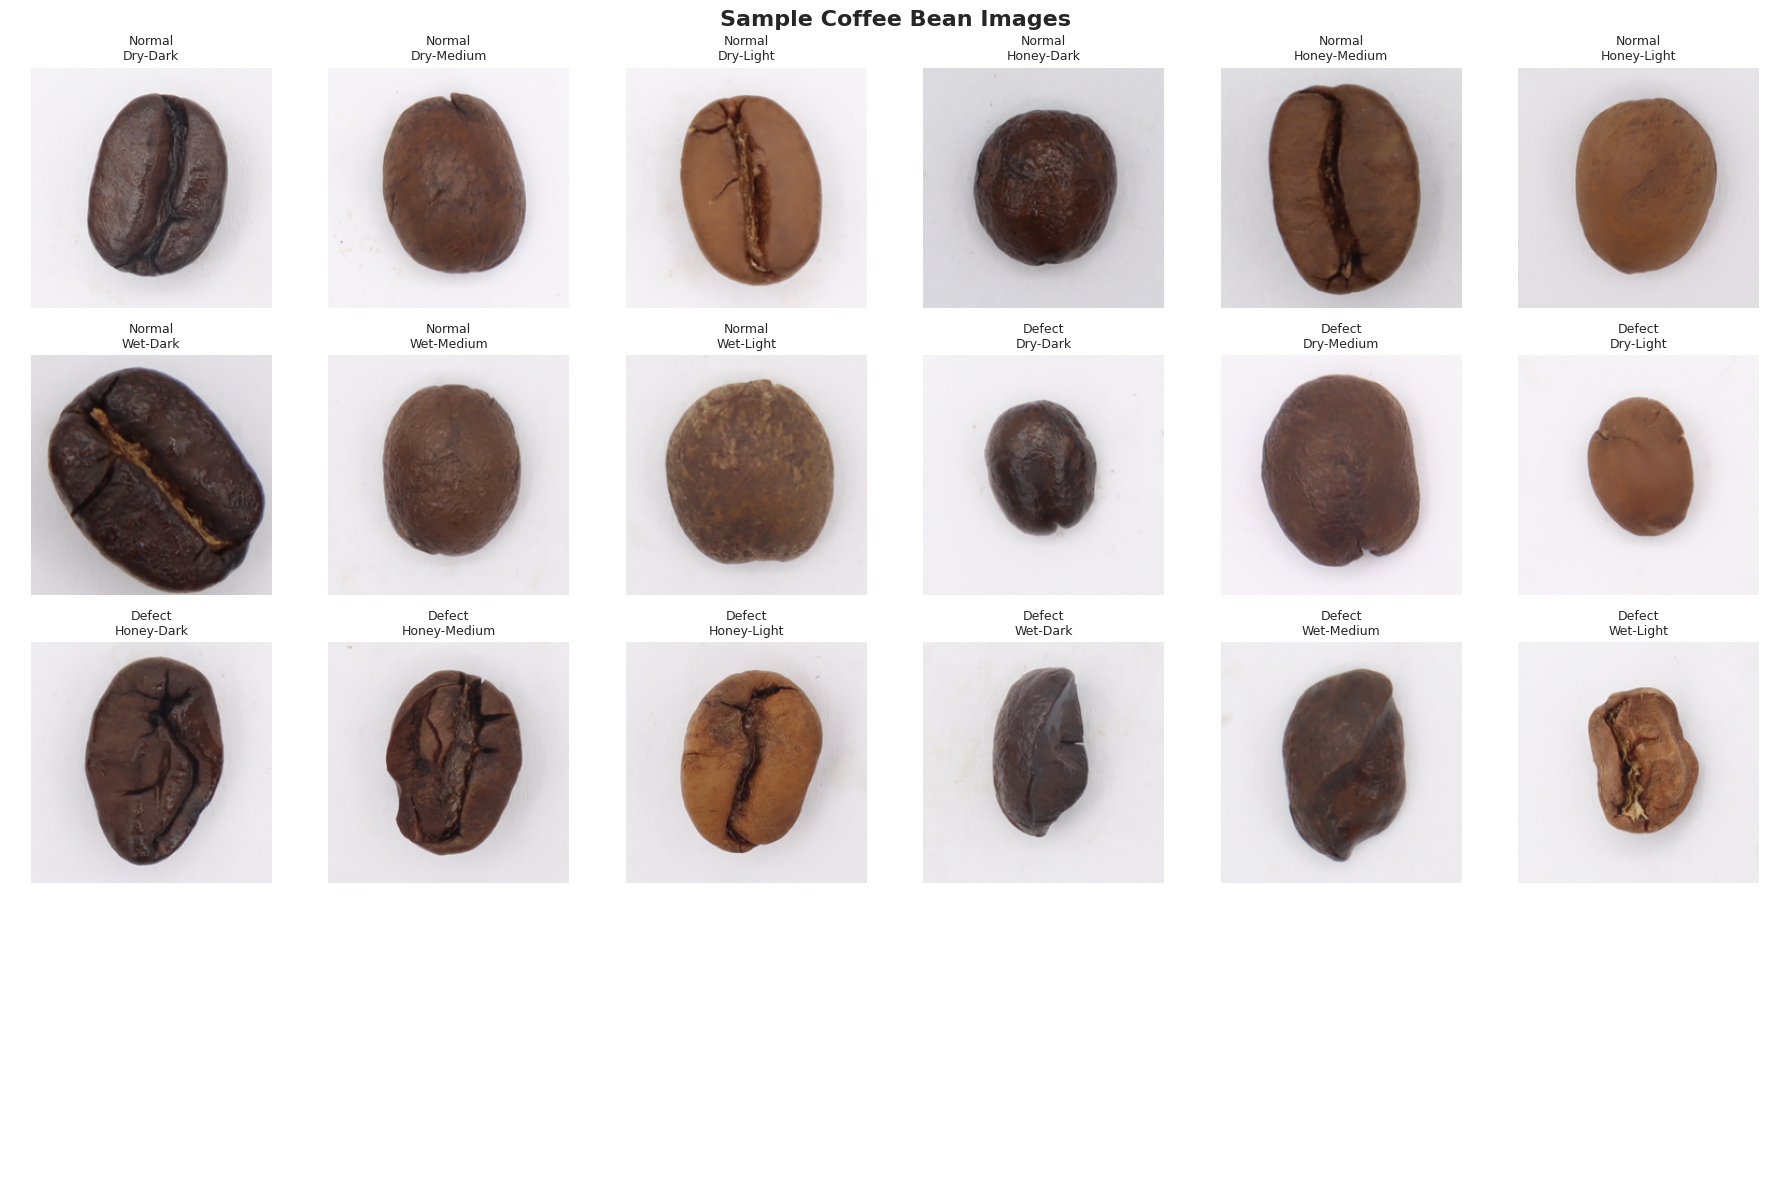

In [9]:
# Figure 2: Sample images visualization

fig, axes = plt.subplots(4, 6, figsize=(18, 12))
fig.suptitle('Sample Coffee Bean Images', fontsize=16, fontweight='bold')

sample_count = 0
for i, class_name in enumerate(['Normal', 'Defect']):
    for j, process in enumerate(['Dry', 'Honey', 'Wet']):
        for roast in ['Dark', 'Medium', 'Light']:
            if sample_count >= 24:
                break

            row = sample_count // 6
            col = sample_count % 6
            ax = axes[row, col]

            # Find sample image
            img_path = DATA_DIR / class_name.lower() / process.lower() / roast.lower()
            if img_path.exists():
                img_files = [p for p in img_path.iterdir() if p.is_file() and p.suffix.lower() in {'.jpg', '.jpeg', '.png'}][:1]

                if img_files:
                    img = Image.open(img_files[0])
                    img_resized = img.resize((224, 224))
                    ax.imshow(img_resized)
                    ax.set_title(f"{class_name}\n{process}-{roast}", fontsize=9)
                    ax.axis('off')
                    sample_count += 1

# Remove empty subplots
for idx in range(sample_count, 24):
    row = idx // 6
    col = idx % 6
    axes[row, col].axis('off')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'sample_images.png', dpi=300, bbox_inches='tight')
print("Saved: sample_images.png")

# 5. COLOR DISTRIBUTION ANALYSIS

Saved: color_analysis.png


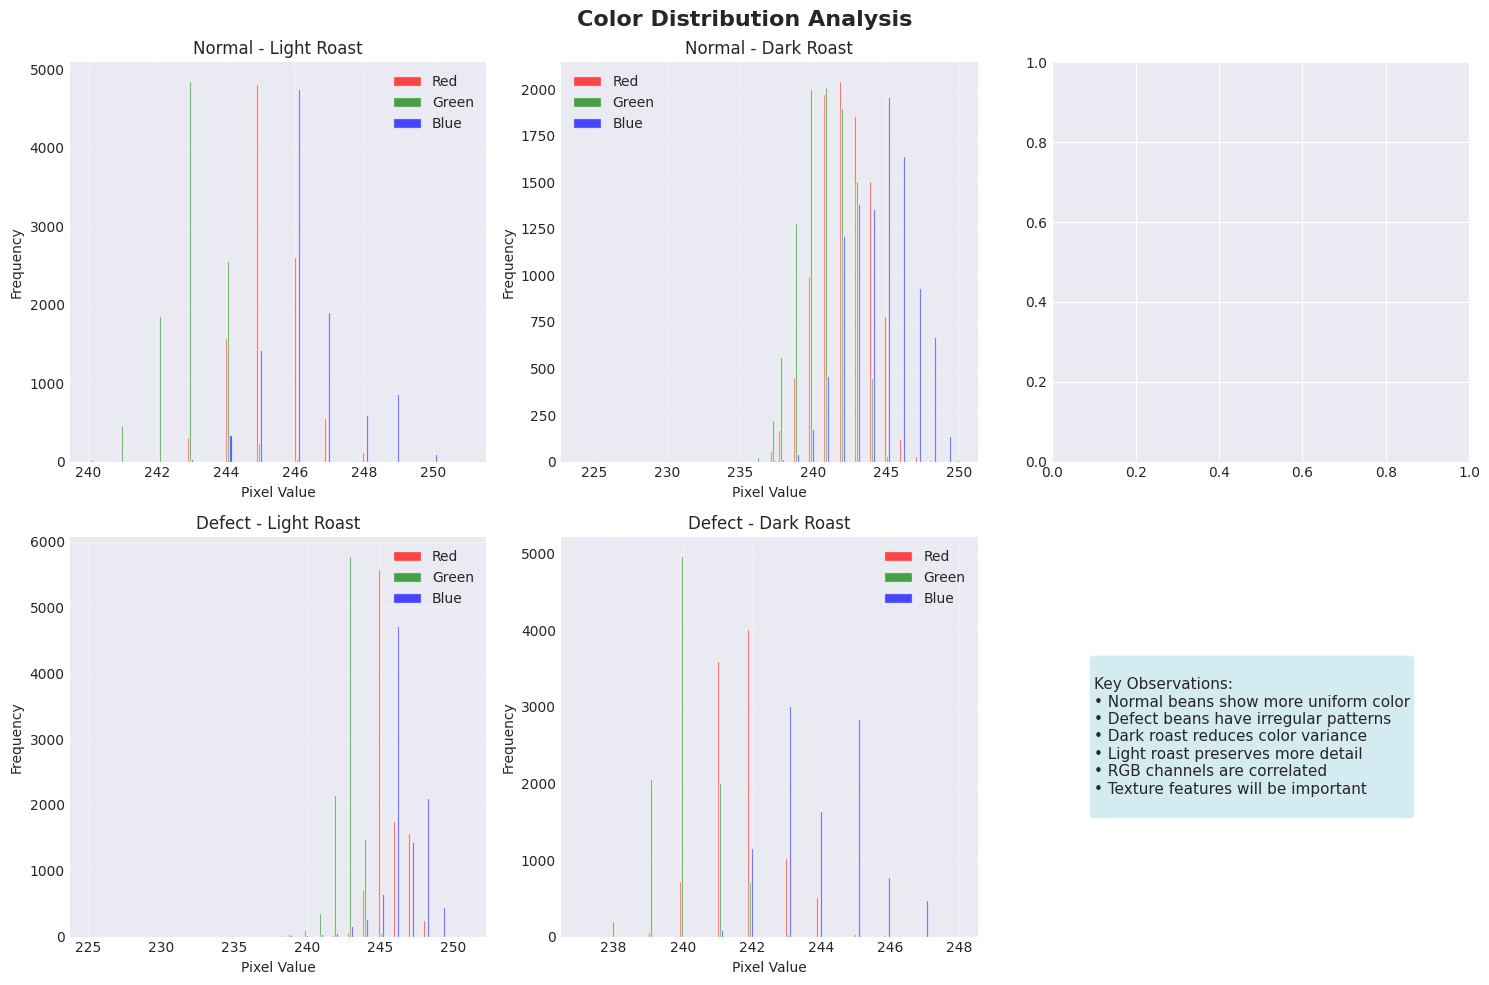

In [10]:
# Color distribution analysis
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Color Distribution Analysis', fontsize=16, fontweight='bold')

for idx, (class_name, roast_level) in enumerate([('Normal', 'Light'), ('Normal', 'Dark'),
                                                  ('Defect', 'Light'), ('Defect', 'Dark')]):
    if idx >= 4:
        break
    row = idx // 2
    col = idx % 2

    # Sample images for color analysis
    color_values = {'R': [], 'G': [], 'B': []}

    for process in ['Dry', 'Honey', 'Wet']:
        img_path = DATA_DIR / class_name.lower() / process.lower() / roast_level.lower()
        if img_path.exists():
            img_files = [p for p in img_path.iterdir() if p.is_file() and p.suffix.lower() in {'.jpg', '.jpeg', '.png'}][:10]

            for img_file in img_files:
                img = cv2.imread(str(img_file))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                color_values['R'].extend(img[:,:,0].flatten())
                color_values['G'].extend(img[:,:,1].flatten())
                color_values['B'].extend(img[:,:,2].flatten())

    if color_values['R']:
        ax = axes[row, col]
        ax.hist([color_values['R'][:10000], color_values['G'][:10000], color_values['B'][:10000]],
                bins=50, alpha=0.7, label=['Red', 'Green', 'Blue'], color=['red', 'green', 'blue'])
        ax.set_title(f'{class_name} - {roast_level} Roast')
        ax.set_xlabel('Pixel Value')
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(True, alpha=0.3)

# Statistical summary
ax = axes[1, 2]
ax.axis('off')
stats_text = """
Key Observations:
• Normal beans show more uniform color
• Defect beans have irregular patterns
• Dark roast reduces color variance
• Light roast preserves more detail
• RGB channels are correlated
• Texture features will be important
"""
ax.text(0.1, 0.5, stats_text, fontsize=11, verticalalignment='center',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'color_analysis.png', dpi=300, bbox_inches='tight')
print("Saved: color_analysis.png")